In [1]:
import numpy as np
import json, os, sys, glob
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping
tf.keras.backend.clear_session()

cur_path=os.getcwd()
sys.path.append(cur_path)

parent_path=os.path.abspath(os.path.join(cur_path,'..'))
sys.path.append(parent_path)

### Load Data

In [3]:
%load_ext autoreload
%autoreload 2

from helpers.load_data import load_sig_tensor

folder_path = r'C:\Users\MichaelB9\Data\S9 AHI\preprocessed'

target_signal='Position'
input_signals=['Flow', 'Mask Pres']

json_files = glob.glob(os.path.join(folder_path,'*.json'))

sig_tensor, target_tensor, subject_names = load_sig_tensor(
    json_files,epoch_size = 60,epoch_step = 30,
    sample_rate = 25, input_signals=input_signals,
    target_signal=target_signal,
    dataset='s9',
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%load_ext autoreload
%autoreload 2

from helpers.load_data import load_sig_tensor

folder_path = r'C:\Users\MichaelB9\Data\Fillius\filtered'

target_signal='Position'
input_signals=['Flow']#, 'mask_pressure']

json_files = glob.glob(os.path.join(folder_path,'*.json'))

sig_tensor1, target_tensor1, subject_names1 = load_sig_tensor(
    json_files,epoch_size = 60,epoch_step = 30,
    sample_rate = 25, input_signals=input_signals,
    target_signal=target_signal, 
    dataset='fillius',
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

sig_tensor['Flow']=np.concatenate([sig_tensor['Flow'], sig_tensor1['Flow']], axis = 1)
target_tensor=np.concatenate([target_tensor,target_tensor1])
subject_names=np.concatenate([subject_names,subject_names1])
sig_tensor1=[]

### Plot octave encoded signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


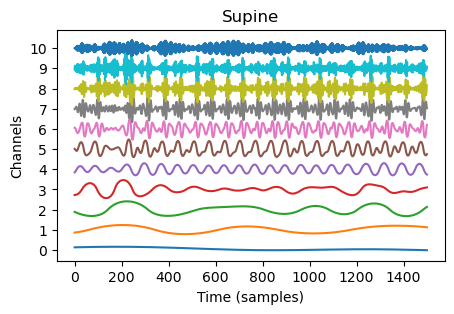

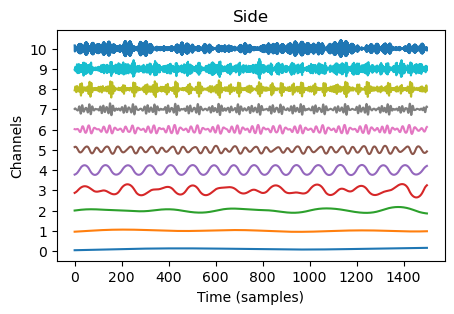

In [64]:
%load_ext autoreload
%autoreload 2
from helpers.plotting import plot_oct

plot_oct(sig_tensor['Flow'][:,5,:],np.where(target_tensor[3]==1,'Supine','Side'))
plot_oct(sig_tensor['Flow'][:,500,:],np.where(target_tensor[300]==1,'Supine','Side'))


## Train a standard 1d CNN

### Split the data

In [5]:
%load_ext autoreload
%autoreload 2

from helpers.load_data import split

X_train, y_train, X_val, y_val, X_test, y_test, all_subs = split(sig_tensor['Flow'],target_tensor,subject_names,train_size=0.85,val_size=0.075,test_size=0.075)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
------------------------------
Train-test-validation split
------------------------------
Training Set Size =  127  subjects
Validation Set Size =  11  subjects
Test Set Size =  12  subjects
------------------------------
train set size =  (93050, 1500, 8) 
 Target distribution 
           0
1  0.524686
0  0.475314
------------------------------
val set size =  (8162, 1500, 8) 
 Target distribution 
           0
1  0.529772
0  0.470228
------------------------------
test set size =  (9094, 1500, 8) 
 Target distribution 
           0
0  0.543215
1  0.456785
------------------------------


In [6]:
X_train1, y_train1, _, _, _, _, _ = split(sig_tensor1['Flow'],target_tensor1,subject_names1,train_size=1,val_size=0,test_size=0)

------------------------------
Train-test-validation split
------------------------------
Training Set Size =  47  subjects
Validation Set Size =  0  subjects
Test Set Size =  0  subjects
------------------------------
train set size =  (39786, 1500, 8) 
 Target distribution 
           0
1  0.525813
0  0.474187
------------------------------
val set size =  (0, 1500, 8) 
 Target distribution 
 Empty DataFrame
Columns: [0]
Index: []
------------------------------
test set size =  (0, 1500, 8) 
 Target distribution 
 Empty DataFrame
Columns: [0]
Index: []
------------------------------


In [7]:
import random
X_train=np.concatenate([X_train,X_train1],axis=0)
y_train=np.concatenate([y_train,y_train1])
idx=np.arange(X_train.shape[0])
random.Random(6).shuffle(idx)
X_train=X_train[idx,:,:]
y_train=y_train[idx]



In [44]:
%load_ext autoreload
%autoreload 2
tf.keras.backend.clear_session()

from build_dnns import build_cnn_1D_4layer

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=30,
    mode='min',
    restore_best_weights=True,
    )

# Build model
cnn_model=build_cnn_1D_4layer(X_train.shape[1],X_train.shape[2],filters=5,kernel_size=5,n_dense=16,dropout=0.4)
# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)    
cnn_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])
# Fit model
H=cnn_model.fit(
    X_train,y_train,
    epochs=100,batch_size=64,
    shuffle=True,validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/100
1463/1463 [==============================] - 113s 71ms/step - loss: 0.6984 - accuracy: 0.5164 - val_loss: 0.6933 - val_accuracy: 0.4935
Epoch 2/100
1463/1463 [==============================] - 94s 64ms/step - loss: 0.6916 - accuracy: 0.5238 - val_loss: 0.6931 - val_accuracy: 0.4816
Epoch 3/100
1463/1463 [==============================] - 95s 65ms/step - loss: 0.6904 - accuracy: 0.5252 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 4/100
1463/1463 [==============================] - 97s 67ms/step - loss: 0.6857 - accuracy: 0.5511 - val_loss: 0.6934 - val_accuracy: 0.5097
Epoch 5/100
1463/1463 [==============================] - 104s 71ms/step - loss: 0.6752 - accuracy: 0.5835 - val_loss: 0.7183 - val_accuracy: 0.5085
Epoch 6/100
1463/1463 [==============================] - 98s 67ms/step - loss: 0.6669 - accuracy: 0.6005 - val_loss: 0.7235 - val_accuracy: 0.5090
Epoch 7/100
1463/1463 [=====

KeyboardInterrupt: 

In [45]:
cnn_model.save(r'C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_02')

INFO:tensorflow:Assets written to: C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_02\assets


INFO:tensorflow:Assets written to: C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_02\assets


In [46]:
%load_ext autoreload
%autoreload 2
tf.keras.backend.clear_session()

from build_dnns import build_cnn_1D_4layer

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=30,
    mode='min',
    restore_best_weights=True,
    )

# Build model
cnn_model=build_cnn_1D_4layer(X_train.shape[1],X_train.shape[2],filters=16,kernel_size=5,n_dense=16,dropout=0.4)
# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)    
cnn_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])
# Fit model
H=cnn_model.fit(
    X_train,y_train,
    epochs=100,batch_size=64,
    shuffle=True,validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/100
1463/1463 [==============================] - 41s 26ms/step - loss: 0.6969 - accuracy: 0.5181 - val_loss: 0.6982 - val_accuracy: 0.4659
Epoch 2/100
1463/1463 [==============================] - 31s 21ms/step - loss: 0.6863 - accuracy: 0.5465 - val_loss: 0.6896 - val_accuracy: 0.5407
Epoch 3/100
1463/1463 [==============================] - 29s 20ms/step - loss: 0.6695 - accuracy: 0.5959 - val_loss: 0.6457 - val_accuracy: 0.6594
Epoch 4/100
1463/1463 [==============================] - 29s 20ms/step - loss: 0.6442 - accuracy: 0.6342 - val_loss: 0.6179 - val_accuracy: 0.6860
Epoch 5/100
1463/1463 [==============================] - 29s 20ms/step - loss: 0.6305 - accuracy: 0.6512 - val_loss: 0.6180 - val_accuracy: 0.6738
Epoch 6/100
1463/1463 [==============================] - 29s 20ms/step - loss: 0.6229 - accuracy: 0.6591 - val_loss: 0.6246 - val_accuracy: 0.6587
Epoch 7/100
1463/1463 [=======

In [47]:
cnn_model.save(r'C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_03')

INFO:tensorflow:Assets written to: C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_03\assets


INFO:tensorflow:Assets written to: C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_03\assets


In [48]:
%load_ext autoreload
%autoreload 2
tf.keras.backend.clear_session()

from build_dnns import build_cnn_1D_4layer

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=30,
    mode='min',
    restore_best_weights=True,
    )

# Build model
cnn_model=build_cnn_1D_4layer(X_train.shape[1],X_train.shape[2],filters=32,kernel_size=5,n_dense=32,dropout=0.4)
# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)    
cnn_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])
# Fit model
H=cnn_model.fit(
    X_train,y_train,
    epochs=100,batch_size=64,
    shuffle=True,validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/100
1463/1463 [==============================] - 48s 31ms/step - loss: 0.6964 - accuracy: 0.5319 - val_loss: 0.6772 - val_accuracy: 0.5574
Epoch 2/100
1463/1463 [==============================] - 44s 30ms/step - loss: 0.6634 - accuracy: 0.6049 - val_loss: 0.6297 - val_accuracy: 0.6696
Epoch 3/100
1463/1463 [==============================] - 44s 30ms/step - loss: 0.6285 - accuracy: 0.6513 - val_loss: 0.5948 - val_accuracy: 0.7113
Epoch 4/100
1463/1463 [==============================] - 44s 30ms/step - loss: 0.6103 - accuracy: 0.6695 - val_loss: 0.5832 - val_accuracy: 0.7225
Epoch 5/100
1463/1463 [==============================] - 42s 29ms/step - loss: 0.6002 - accuracy: 0.6789 - val_loss: 0.5832 - val_accuracy: 0.7240
Epoch 6/100
1463/1463 [==============================] - 44s 30ms/step - loss: 0.5919 - accuracy: 0.6857 - val_loss: 0.5810 - val_accuracy: 0.7281
Epoch 7/100
1463/1463 [=======

In [49]:
cnn_model.save(r'C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_04')

INFO:tensorflow:Assets written to: C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_04\assets


INFO:tensorflow:Assets written to: C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_04\assets


In [8]:
%load_ext autoreload
%autoreload 2
tf.keras.backend.clear_session()

from build_dnns import build_cnn_1D_5layer

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=30,
    mode='min',
    restore_best_weights=True,
    )

# Build model
cnn_model=build_cnn_1D_5layer(X_train.shape[1],X_train.shape[2],filters=16,kernel_size=5,n_dense=32,dropout=0.4)
# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)    
cnn_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])
# Fit model
H=cnn_model.fit(
    X_train,y_train,
    epochs=100,batch_size=64,
    shuffle=True,validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/100
2076/2076 [==============================] - 61s 28ms/step - loss: 0.7020 - accuracy: 0.5111 - val_loss: 0.6925 - val_accuracy: 0.5282
Epoch 2/100
2076/2076 [==============================] - 47s 23ms/step - loss: 0.6917 - accuracy: 0.5233 - val_loss: 0.6922 - val_accuracy: 0.5279
Epoch 3/100
2076/2076 [==============================] - 48s 23ms/step - loss: 0.6852 - accuracy: 0.5487 - val_loss: 0.6820 - val_accuracy: 0.5638
Epoch 4/100
2076/2076 [==============================] - 48s 23ms/step - loss: 0.6671 - accuracy: 0.5930 - val_loss: 0.6963 - val_accuracy: 0.5234
Epoch 5/100
2076/2076 [==============================] - 48s 23ms/step - loss: 0.6557 - accuracy: 0.6145 - val_loss: 0.7058 - val_accuracy: 0.5252
Epoch 6/100
2076/2076 [==============================] - 48s 23ms/step - loss: 0.6488 - accuracy: 0.6240 - val_loss: 0.6922 - val_accuracy: 0.5349
Epoch 7/100
2076/2076 [=======

In [51]:
cnn_model.save(r'C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_05')

INFO:tensorflow:Assets written to: C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_05\assets


INFO:tensorflow:Assets written to: C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_05\assets


<Figure size 640x480 with 0 Axes>

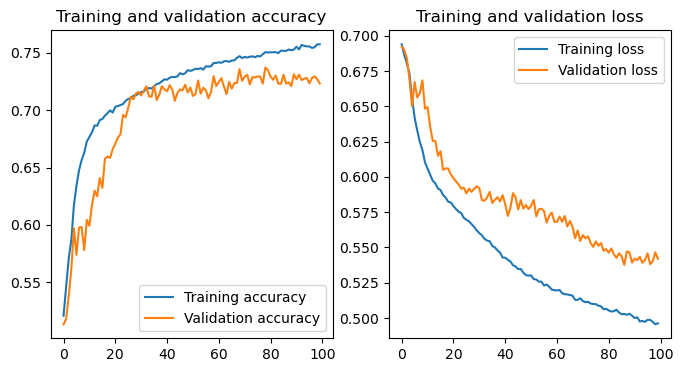

<Figure size 640x480 with 0 Axes>

In [53]:
train_val_curve(H)

In [77]:
X_train.shape

(133392, 1500, 11)

In [80]:
X_train.shape

(133392, 1500, 11)

In [84]:
y_train

array([0, 0, 1, ..., 1, 1, 1])

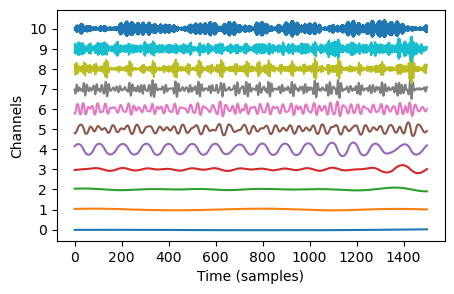

In [85]:
plot_oct(X_train[30,:,:].T)

In [78]:
H=cnn_model.fit(
    X_train,y_train,
    epochs=100,batch_size=64,
    shuffle=True,validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    )

Epoch 1/100
2085/2085 [==============================] - 54s 26ms/step - loss: 0.6924 - accuracy: 0.5247 - val_loss: 0.6940 - val_accuracy: 0.4935
Epoch 2/100
2085/2085 [==============================] - 47s 22ms/step - loss: 0.6920 - accuracy: 0.5247 - val_loss: 0.6945 - val_accuracy: 0.4935
Epoch 3/100
2085/2085 [==============================] - 47s 23ms/step - loss: 0.6919 - accuracy: 0.5247 - val_loss: 0.6948 - val_accuracy: 0.4935
Epoch 4/100
2085/2085 [==============================] - 47s 22ms/step - loss: 0.6919 - accuracy: 0.5247 - val_loss: 0.6949 - val_accuracy: 0.4935
Epoch 5/100
2085/2085 [==============================] - 47s 22ms/step - loss: 0.6919 - accuracy: 0.5247 - val_loss: 0.6950 - val_accuracy: 0.4935
Epoch 6/100
2085/2085 [==============================] - 47s 23ms/step - loss: 0.6919 - accuracy: 0.5247 - val_loss: 0.6950 - val_accuracy: 0.4935
Epoch 7/100
1842/2085 [=========================>....] - ETA: 5s - loss: 0.6918 - accuracy: 0.5256

KeyboardInterrupt: 

### Model Evaluation

272/272 [==============================] - 1s 4ms/step


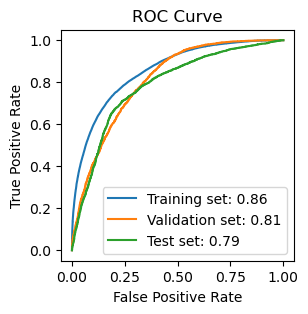

In [56]:
from helpers.plotting import train_val_curve, plot_roc
from sklearn.metrics import *


y_train_pred=cnn_model.predict(X_train)
y_val_pred=cnn_model.predict(X_val)
y_test_pred=cnn_model.predict(X_test)

plt.figure(figsize=(3,3))
plot_roc(y_train,y_train_pred,0.5, label='Training set')
plot_roc(y_val,y_val_pred,0.5, label='Validation set')
plot_roc(y_test,y_test_pred,0.5, label='Test set')

In [63]:
print(classification_report(y_val,sp.ndimage.median_filter(y_val_pred,15)>0.5))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      4065
           1       0.73      0.72      0.73      3961

    accuracy                           0.73      8026
   macro avg       0.73      0.73      0.73      8026
weighted avg       0.73      0.73      0.73      8026



## Train a multiheaded model with flow and Pressure

In [41]:
%load_ext autoreload
%autoreload 2

from helpers.load_data import split

Xflow_train, y_train, Xflow_val, y_val, Xflow_test, y_test = split(sig_tensor['flow'],target_tensor,subject_names,train_size=0.85,val_size=0.075,test_size=0.075)
Xpres_train, _, Xpres_val, _, Xpres_test, _ = split(sig_tensor['mask_pressure'],target_tensor,subject_names,train_size=0.85,val_size=0.075,test_size=0.075)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
------------------------------
Train-test-validation split
------------------------------
Training Set Size =  39  subjects
Validation Set Size =  3  subjects
Test Set Size =  5  subjects
------------------------------
train set size =  (16627, 1500, 8) 
 Target distribution 
           0
1  0.516088
0  0.483912
------------------------------
val set size =  (1119, 1500, 8) 
 Target distribution 
           0
1  0.589812
0  0.410188
------------------------------
test set size =  (2147, 1500, 8) 
 Target distribution 
           0
1  0.570098
0  0.429902
------------------------------
------------------------------
Train-test-validation split
------------------------------
Training Set Size =  39  subjects
Validation Set Size =  3  subjects
Test Set Size =  5  subjects
------------------------------
train set size =  (16627, 1500, 8) 
 Target distribution 
           0
1  0.516088
0  0.483912
------

In [42]:
%load_ext autoreload
%autoreload 2
tf.keras.backend.clear_session()
from build_dnns import build_2head_cnn

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)

cnn_model2head=build_2head_cnn(Xflow_train.shape[1],Xflow_train.shape[2],filters=16,kernel_size=16,n_dense=16,dropout=0.3)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)    
cnn_model2head.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])

H=cnn_model2head.fit(
    [Xflow_train,Xpres_train],y_train, 
    epochs=15,batch_size=64,
    shuffle=True,validation_data=([Xflow_val,Xpres_val],y_val), 
    callbacks=[early_stopping],
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/15
260/260 [==============================] - 14s 51ms/step - loss: 0.6995 - accuracy: 0.5146 - val_loss: 0.6852 - val_accuracy: 0.5898
Epoch 2/15
260/260 [==============================] - 14s 54ms/step - loss: 0.6847 - accuracy: 0.5465 - val_loss: 0.6866 - val_accuracy: 0.5648
Epoch 3/15
260/260 [==============================] - 16s 60ms/step - loss: 0.6652 - accuracy: 0.5952 - val_loss: 0.7142 - val_accuracy: 0.5907
Epoch 4/15
260/260 [==============================] - 15s 58ms/step - loss: 0.6303 - accuracy: 0.6520 - val_loss: 0.7457 - val_accuracy: 0.5550
Epoch 5/15
260/260 [==============================] - 17s 64ms/step - loss: 0.5767 - accuracy: 0.7119 - val_loss: 0.9964 - val_accuracy: 0.5657
Epoch 6/15
260/260 [==============================] - 15s 58ms/step - loss: 0.5480 - accuracy: 0.7309 - val_loss: 0.8721 - val_accuracy: 0.5648
Epoch 6: early stopping


### Model Evaluation

68/68 [==============================] - 0s 4ms/step


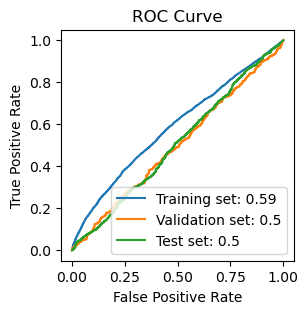

In [43]:
from helpers.plotting import train_val_curve, plot_roc
from sklearn.metrics import *

# train_val_curve(H)

y_train_pred=cnn_model2head.predict([Xflow_train,Xpres_train])
y_val_pred=cnn_model2head.predict([Xflow_val, Xpres_val])
y_test_pred=cnn_model2head.predict([Xflow_test, Xpres_test])

plt.figure(figsize=(3,3))
plot_roc(y_train,y_train_pred,0.5, label='Training set')
plot_roc(y_val,y_val_pred,0.5, label='Validation set')
plot_roc(y_test,y_test_pred,0.5, label='Test set')

In [44]:
print(classification_report(y_val,sp.ndimage.median_filter(y_val_pred,15)>0.5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       459
           1       0.59      1.00      0.74       660

    accuracy                           0.59      1119
   macro avg       0.29      0.50      0.37      1119
weighted avg       0.35      0.59      0.44      1119



c:\Users\MichaelB9\Anaconda3\envs\deepdive\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MichaelB9\Anaconda3\envs\deepdive\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MichaelB9\Anaconda3\envs\deepdive\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
